Stacking with Least Absolute Deviation (LAD) Regression

https://real-statistics.com/multiple-regression/lad-regression/<br>
https://scikit-lego.netlify.app/linear-models.html#Least-Absolute-Deviation-Regression<br>


[AmbrosM](https://www.kaggle.com/ambrosm) won **PSS3-E11 competetion** with a ZOO of models, using a **Ridge with positive coefficients** to stack different predictions. See https://www.kaggle.com/code/ambrosm/pss3e11-zoo-of-models<br>
But evaluation metric was : **Root Mean Squared Log Error (RMLSE)**

In current competition, the evaluation metric is **Mean Absolute Error**, Ridge will probably not work.

Fortunately, a **[Least Absolute Deviation Regression](https://real-statistics.com/multiple-regression/lad-regression)** is available in **[sklego](https://scikit-lego.netlify.app/linear-models.html#Least-Absolute-Deviation-Regression)**. 


This notebook is in 3 parts:
- part 1 : reproduction of [Patrick Blackwill](https://www.kaggle.com/paddykb) [notebook](https://www.kaggle.com/code/paddykb/ps-s3e14-flaml-bfi-be-bop-a-blueberry-do-dah) to get some oof predictions
- part 2 : reproduction of one of my previous [notebook](https://www.kaggle.com/code/adaubas/pss3e14-cv-lgbm-fe-decomposition) to get some others oof predictions
- part 3 : blend, the goal of this notebook

# Part 1 : FLAML BFI Be-bop-a-blueberry-do-dah

Orininal notebook is there : https://www.kaggle.com/code/paddykb/ps-s3e14-flaml-bfi-be-bop-a-blueberry-do-dah

I do not change anything. Thanks to [Patrick Blackwill](https://www.kaggle.com/paddykb)

In [1]:
%%capture
!pip install flaml

## Introduction

Brute force baseline: throw everything into flaml and churn.

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)

from pathlib import Path
import random

from plotnine import * 

from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error

from flaml import AutoML

%matplotlib inline
%config InlineBackend.figure_format='retina'

INPUT_DIR = Path('/kaggle/input/playground-series-s3e14/')

In [3]:
TARGET_NAME = 'yield'

# nested CV to ensure true out of fold metrics
N_OUTER_FOLDS = 9
N_FOLDS = 10
N_REPEATS = 10


FIRST_TIME_BUDGET = 1 #1200  # Exploration Budget for first fit
MIN_TIME_BUDGET = 1 ##10     # subseqent fit times are reduced

INCLUDE_ORIGINAL = True

RANDOM_STATE = 2112 # overture...

np.random.seed(RANDOM_STATE)

In [4]:
test_data = pd.read_csv(INPUT_DIR / 'test.csv')
test_data['data_type'] = 0

train_data = pd.read_csv(INPUT_DIR / 'train.csv')
train_data['data_type'] = 0

if INCLUDE_ORIGINAL:
    original_data = pd.read_csv('/kaggle/input/wild-blueberry-yield-prediction-dataset/WildBlueberryPollinationSimulationData.csv')
    original_data['data_type'] = 1
    train_data = pd.concat([train_data, original_data.drop(columns=['Row#'])]).reset_index(drop=True)


features = (['MinOfLowerTRange', 'RainingDays', 'fruitmass', 'fruitset', 'seeds', 'bumbles', 'clonesize']
            +  ([] if INCLUDE_ORIGINAL else ['data_type']))

def fe(df):
    # a couple of rows seem odd 
    # probably not enough to make much of a difference
    df['RainingDays'] = np.select(
        condlist=[
            df['RainingDays'] == 26, 
            df['RainingDays'] == 33],
        choicelist= [24, 34],
        default=df['RainingDays'])
    
fe(train_data)
fe(test_data)

see https://www.kaggle.com/competitions/playground-series-s3e14/discussion/407327 for a discussion of postprocessing.

In [5]:
unique_targets = np.unique(train_data["yield"])
def mattop_post_process(preds):
     return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

In [6]:
train_data.filter(features).describe().T

,count,mean,std,min,25%,50%,75%,max
MinOfLowerTRange,16066.0,28.661988,3.195960,24.300000,27.000000,30.000000,30.000000,33.000000
RainingDays,16066.0,18.643737,11.680365,1.000000,16.000000,16.000000,24.000000,34.000000
fruitmass,16066.0,0.446525,0.037200,0.311921,0.418867,0.446570,0.474777,0.535660
fruitset,16066.0,0.502711,0.074639,0.192732,0.457833,0.506686,0.560709,0.652144
seeds,16066.0,36.162894,4.048407,22.079199,33.232449,36.047770,39.158238,46.585105
bumbles,16066.0,0.286556,0.060249,0.000000,0.250000,0.250000,0.380000,0.585000
clonesize,16066.0,19.659374,6.618134,10.000000,12.500000,25.000000,25.000000,40.000000


## Fit FLAML

A bit of jiggerypokery to ensure we have true OOF predictions.

In [7]:
from flaml.automl.model import LGBMEstimator

# customisation to set LGB objective to L1 loss
class MyLGBM(LGBMEstimator):
    """customise objective for l1 loss"""

    def __init__(self, **config):
        super().__init__(objective="regression_l1", **config)

In [8]:
def fold_mae(y, preds, data_type):
    # evaluate against competition training data only
    return mean_absolute_error(y[data_type==0], preds[data_type==0])

def get_fi(automl, estimator_name, X, y):
    # extract permutation feature importance
    # from the model.
    
    fi = pd.DataFrame({
        'estimator_name': [],
        'Feature': [],
        'Importance': []})
    
    try:
        # ensemble - use lgbm
        est = automl.model.named_estimators_['lgbm']
        imp = permutation_importance(est, X, y)
        fi = pd.DataFrame({
            'Importance': imp.importances_mean,
            'Feature': X.columns})
    except:
        try:
            est = automl.model
            imp = permutation_importance(est, X, y)
            fi = pd.DataFrame({
                'Importance': imp.importances_mean,
                'Feature': X.columns})
        except:
            pass
    
    if len(fi) > 0:
        fi = fi.assign(estimator_name=estimator_name)
    
    return fi


class AutoMLFitter:
    # A wrap of the automl call to allow us to
    # decrease the time budget for each call
    # And keep track of the best parameters found
    
    def __init__(self, name, time_budget, estimator_list=[], best_config=None, n_folds=10):
        self.name = name
        self.time_budget = time_budget
        self.estimator_list = estimator_list
        self.best_config = best_config
        self.n_folds = n_folds

    def fit_automl(self, random_state, X, y):

        automl_settings = {
            "time_budget": self.time_budget,
            "metric": 'mae',
            "task": 'regression',
            "log_file_name": "",
            "ensemble": False,
            "eval_method": 'cv',
            "n_splits": self.n_folds,
            "seed": random_state,
            "verbose": 0,
            "estimator_list": self.estimator_list
        }

        # time budget is decreased on each fit.
        self.time_budget //= 1.5
        if self.time_budget < MIN_TIME_BUDGET:
            self.time_budget = MIN_TIME_BUDGET

        automl = AutoML()
        automl.add_learner(learner_name='my_lgbm', learner_class=MyLGBM)
        automl_settings["estimator_list"] = ['my_lgbm' ]  # change the estimator list
        
        automl.fit(X, y, starting_points=self.best_config, **automl_settings)
        self.best_config = automl.best_config_per_estimator

        return automl

In [9]:
def fit_nested_automl(model_fitters, random_state, train_data, test_data, features):
                               
    k_fold = KFold(n_splits=N_OUTER_FOLDS, random_state=random_state, shuffle=True)
    
    fast_fis = []
    oof_metrics = []
    test_preds = np.zeros(len(test_data))
    oof_preds = np.zeros(len(train_data))
    
    print('OOF Metric: ', end='')
    for train_index, test_index in k_fold.split(train_data, train_data[TARGET_NAME]):
        tr, vl = train_data.loc[train_index], train_data.loc[test_index]
        
        # for each model:
        oof_pred = np.zeros(len(vl))
        test_pred = np.zeros(len(test_data))
        best_loss = 0
        
        for model_fitter in model_fitters:
            
            automl = model_fitter.fit_automl(
                random_state, 
                tr.filter(features), 
                tr[TARGET_NAME].values)
        
            oof_pred  += automl.predict(vl.filter(features)) / len(model_fitters)
            test_pred += automl.predict(test_data.filter(features)) / len(model_fitters)
            best_loss += automl.best_loss / (len(model_fitters))
        
            fast_fi =  get_fi(automl, model_fitter.name, vl.filter(features), vl[TARGET_NAME])
            fast_fis.append(fast_fi)
        
        oof_metric = fold_mae(
            vl[TARGET_NAME].values, 
            oof_pred, 
            vl['data_type'].values)
        
        print(f'{oof_metric:4.1f}', end=' ')
        
        oof_preds[test_index] += oof_pred
        test_preds += test_pred / N_OUTER_FOLDS
        fast_fis.append(fast_fi)
        oof_metrics.append(oof_metric)

    return oof_preds, test_preds, fast_fis, oof_metrics


def fit(model_fitters, train_data, test_data, features):
    test_preds = np.zeros(len(test_data))
    oof_preds = np.zeros(len(train_data))
    oof_metrics = []
    oof_fold_metrics = []
    fast_fis = []
    for i in range(N_REPEATS): 
        # fit
        oof_pred, test_pred, fast_fi, oof_fold_metric = fit_nested_automl(
            model_fitters,
            RANDOM_STATE + i,
            train_data.sample(frac=1),
            test_data,
            features)

        oof_metric = fold_mae(
            train_data[TARGET_NAME].values, 
            oof_pred, 
            train_data['data_type'].values)
        
        oof_metric_pp = fold_mae(
            train_data[TARGET_NAME].values, 
            mattop_post_process(oof_pred), 
            train_data['data_type'].values)

        test_preds += (test_pred) / N_REPEATS
        oof_preds += (oof_pred) / N_REPEATS

        oof_fold_metrics.extend(oof_fold_metric)
        fast_fis.extend(fast_fi)

        print(f'| Repeat {i}: {oof_metric:4.1f} mattop postprocessing {oof_metric_pp:4.1f}')
        
    return oof_preds, test_preds, oof_fold_metrics, fast_fis

In [10]:
tr = train_data.sample(frac=1, random_state=RANDOM_STATE)

model_fitter = AutoMLFitter(
    name='model',
    time_budget= FIRST_TIME_BUDGET, 
    n_folds=5) # nested CV: 8/9 * 9/10 = 80%, equivalent to 5 folds

# here's one I made earlier:
# running the fitter with a longer budget will discover these 
# hyperparameters:
model_fitter.best_config = {
    'my_lgbm': {'n_estimators': 265, 'num_leaves': 93, 'min_child_samples': 20, 
                'learning_rate': 0.05533790147941807, 'log_max_bin': 10, 
                'colsample_bytree': 0.8809128870084636, 'reg_alpha': 0.0009765625, 
                'reg_lambda': 0.015589408048174165}}

model_fitter.fit_automl(
    RANDOM_STATE, 
    tr.filter(features), 
    tr[TARGET_NAME].values)

model_fitter.time_budget = MIN_TIME_BUDGET
model_fitter.n_folds = N_FOLDS

print(model_fitter.best_config)

models = [model_fitter]
# model fit & output
oof_preds, test_preds, oof_fold_metrics, fast_fis = fit(models, train_data, test_data, features)

{'my_lgbm': {'n_estimators': 265, 'num_leaves': 93, 'min_child_samples': 20, 'learning_rate': 0.05533790147941807, 'log_max_bin': 10, 'colsample_bytree': 0.8809128870084636, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.01558940804817417}}
OOF Metric: 355.9 331.0 328.2 328.8 316.1 340.5 346.5 355.5 353.1 | Repeat 0: 339.5 mattop postprocessing 339.3
OOF Metric: 350.5 337.4 337.5 333.9 358.8 340.1 343.2 343.6 316.0 | Repeat 1: 340.1 mattop postprocessing 340.0
OOF Metric: 345.3 348.1 338.4 334.4 347.8 333.1 341.4 330.5 334.1 | Repeat 2: 339.3 mattop postprocessing 339.2
OOF Metric: 324.7 323.3 342.6 351.1 335.5 346.1 335.9 351.0 343.8 | Repeat 3: 339.3 mattop postprocessing 339.1
OOF Metric: 332.0 346.5 337.2 332.4 331.0 347.1 339.8 353.9 336.2 | Repeat 4: 339.6 mattop postprocessing 339.5
OOF Metric: 352.0 338.9 356.6 324.9 340.6 346.9 344.5 326.1 328.2 | Repeat 5: 339.9 mattop postprocessing 339.8
OOF Metric: 315.4 345.8 341.1 332.1 345.7 353.6 342.1 340.4 339.7 | Repeat 6: 339.6 mattop 

## Model Quality

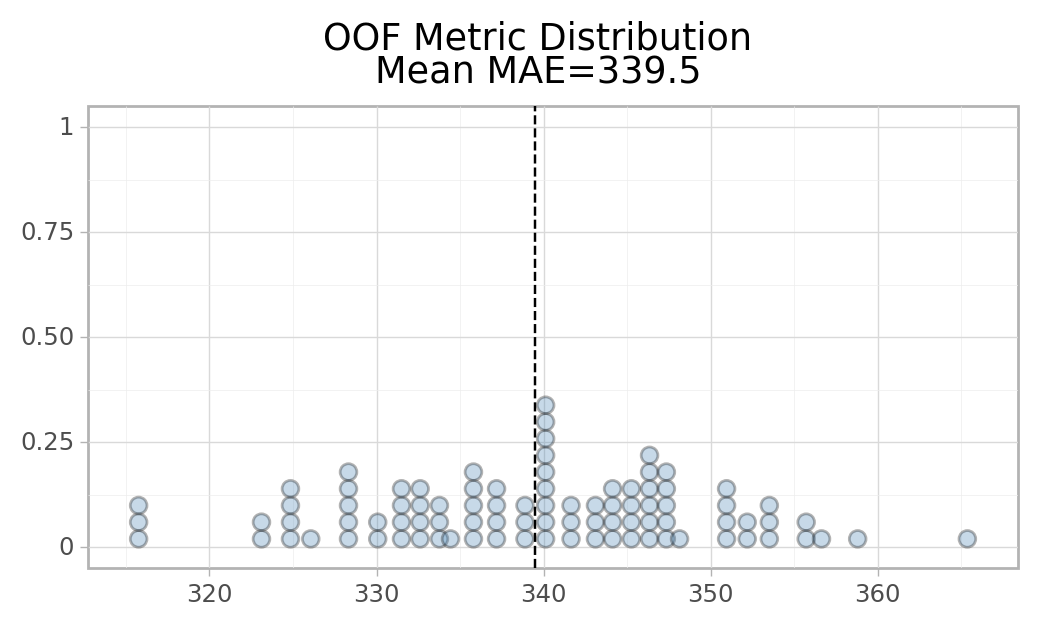

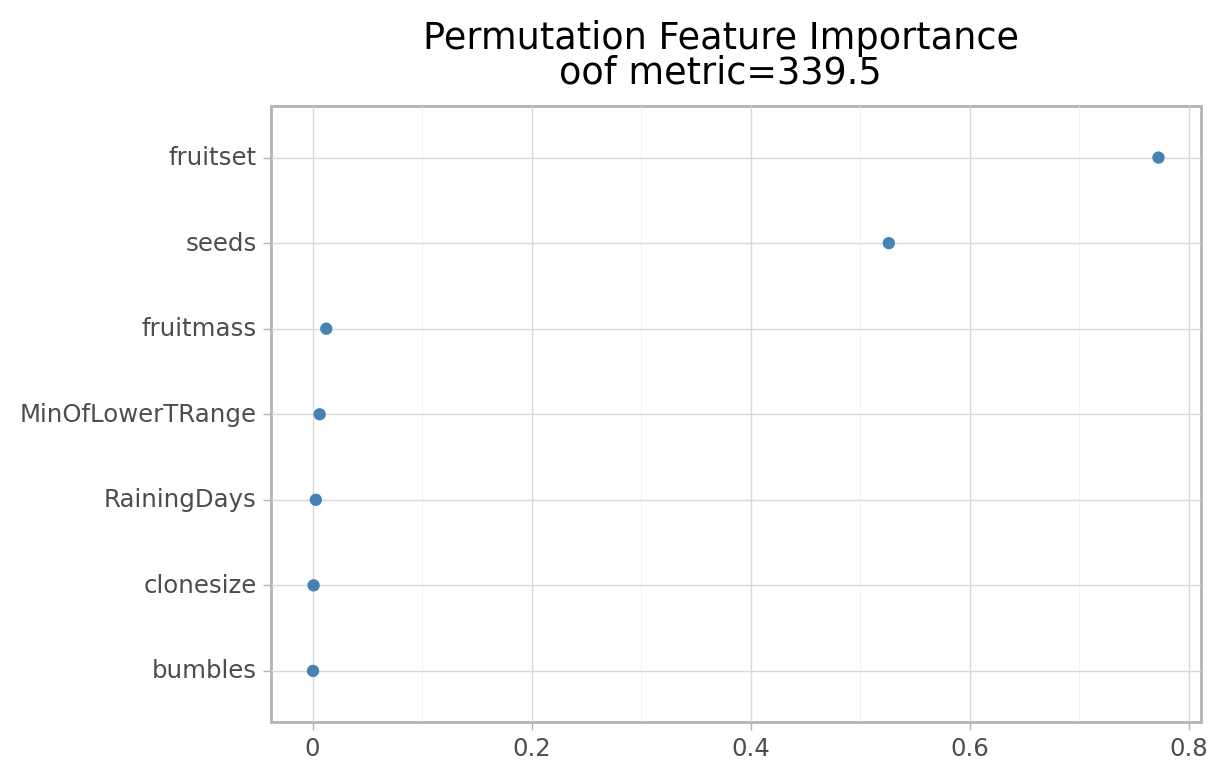


            Feature  mean_imp   std_imp
2           bumbles  0.000412  0.000358
3         clonesize  0.000955  0.000665
1       RainingDays  0.002963  0.001034
0  MinOfLowerTRange  0.006465  0.001562
4         fruitmass  0.012504  0.002815
6             seeds  0.526175  0.030769
5          fruitset  0.772388  0.043929


In [11]:
df_metrics = pd.DataFrame({'oof': oof_fold_metrics})
print(ggplot(df_metrics, aes(x='oof'))
    + theme_light()
    + theme(figure_size=(6, 3))
    + geom_dotplot(alpha=0.3, binwidth = 1, fill='SteelBlue')
    + geom_vline(xintercept=np.mean(oof_fold_metrics), linetype='dashed')
    + labs(
        y = '', x='', 
        title = f'OOF Metric Distribution\nMean MAE={np.mean(oof_fold_metrics):4.1f}'))

df_importance = pd.concat(fast_fis).sort_values(['Importance'])
if len(df_importance) > 0:
    df_importance_mean = (
        df_importance
        .groupby(['Feature'], as_index=False)
        .agg(mean_imp=('Importance', 'mean'), std_imp=('Importance', 'std'))
        .sort_values(['mean_imp']))

    feature_list = df_importance_mean['Feature'].tolist()
    feature_cat  = pd.Categorical(df_importance_mean['Feature'], categories=feature_list) #[::-1])
    
    df_importance_mean = (df_importance_mean
        .assign(
            feature_cat = feature_cat,
            mean_imp_min = lambda x: x['mean_imp'] - 2 * x['std_imp'],
            mean_imp_max = lambda x: x['mean_imp'] + 2 * x['std_imp']))
    
    df_importance = df_importance.merge(df_importance_mean.filter(['Feature', 'feature_cat']))

    print(ggplot(df_importance, aes(y='feature_cat', x='Importance')) 
        + theme_light()
        + theme(figure_size=(6, 4))
        #+ geom_jitter(alpha=0.2, size=0.5, height=0.1)
        + geom_point(mapping=aes(x='mean_imp'), colour='SteelBlue', data=df_importance_mean) 
        #+ geom_errorbarh(
        #    mapping=aes(x='mean_imp', xmin='mean_imp_min', xmax='mean_imp_max'), 
        #    alpha=0.5,  data=df_importance_mean)  
        + labs(
            y = '', x='', 
            title = (f'Permutation Feature Importance\n'
                f'oof metric={np.mean(oof_fold_metrics):4.1f}'))
        #+ facet_wrap('estimator_name', ncol=2)
         )
    
if len(df_importance) > 0:
    print(df_importance_mean.filter(['Feature', 'mean_imp', 'std_imp']).head(20))

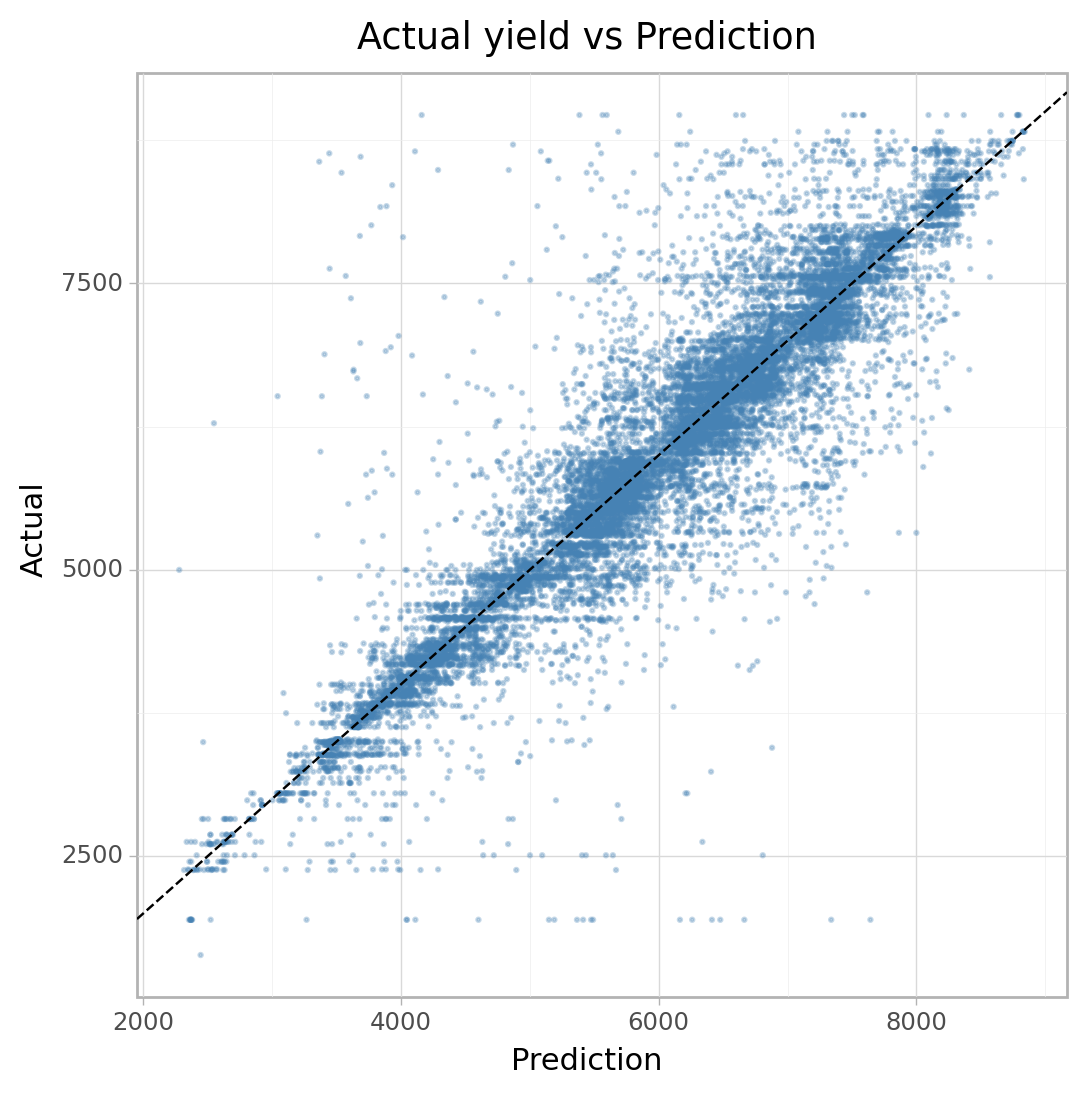

In [12]:
pred_data = train_data.assign(pred=oof_preds)
print(ggplot(pred_data, aes(x='pred', y=TARGET_NAME))
    + theme_light()
    + theme(figure_size=(6, 6))
    + geom_point(alpha=0.3, size=0.3, colour='SteelBlue')
    + geom_abline(intercept=0, slope=1, linetype='dashed')
    + labs(y='Actual', x='Prediction', title=f'Actual {TARGET_NAME} vs Prediction'))

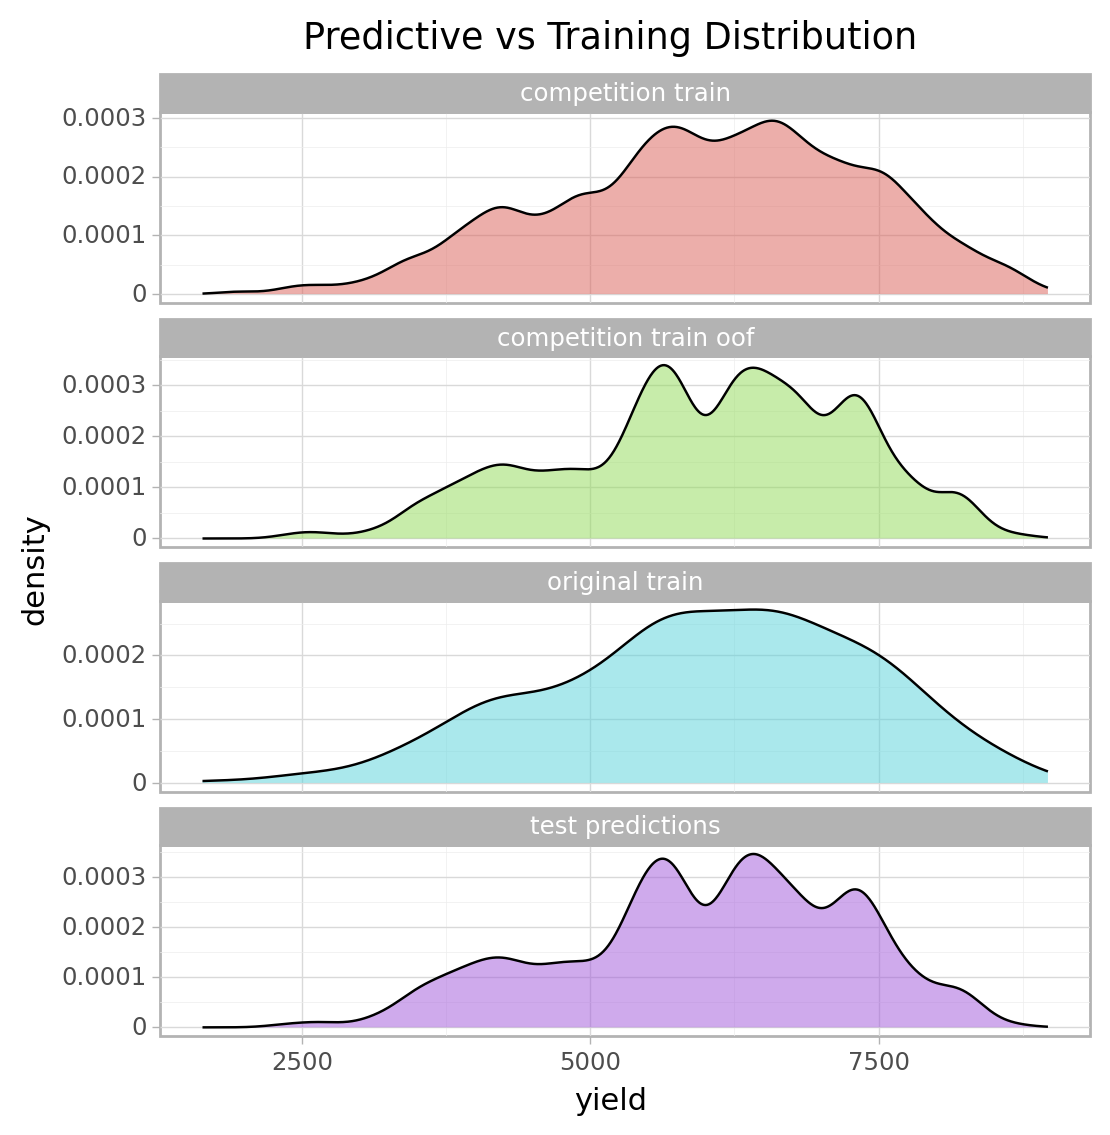

In [13]:
df_dist = pd.concat([
    (train_data
        .assign(
            source=lambda x: 
                np.where(x['data_type'] == 0, 'competition train', 'original train'))
        .filter([TARGET_NAME, 'source'])),
    (test_data
        .filter(['Strength'])
        .assign(**{TARGET_NAME: test_preds})
        .assign(source='test predictions')),
    (pred_data
        .filter(['pred'])
        .rename(columns={'pred': TARGET_NAME})
        .assign(source='competition train oof'))])


print(ggplot(df_dist, aes(x=TARGET_NAME, fill='source'))
    + theme_light()
    + theme(
        figure_size=(6, 6),
        legend_position='none')
    + geom_density(alpha=0.5) 
    + facet_wrap('source', ncol=1, scales='free_y')
    + labs(title='Predictive vs Training Distribution'))

# Part 2 : one of my previous notebook
https://www.kaggle.com/code/adaubas/pss3e14-cv-lgbm-fe-decomposition

In [14]:
SEED = 1984
target = "yield"

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

class PLSRegressionWrapper(PLSRegression):
    def transform(self, X):
        return super().transform(X)
    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)

import lightgbm as lgb

In [15]:
train =  pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv', index_col = "id")
test =  pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv', index_col = "id")
origin = pd.read_csv('../input/wild-blueberry-yield-prediction-dataset/WildBlueberryPollinationSimulationData.csv', index_col = "Row#")
origin.index.name = "id"

train.loc[train["RainingDays"]==26, "RainingDays"] = 24
test.loc[test["RainingDays"]==33, "RainingDays"] = 34

for df in [train, test, origin]:
    df.loc[df["MaxOfUpperTRange"].isin([71.9, 79, 89]), "MaxOfUpperTRange"] = 86

for df in [train, test, origin]:
    display(df["RainingDays"].value_counts())
    display(df["MaxOfUpperTRange"].value_counts())

16.00    4361
24.00    3838
34.00    3521
1.00     3521
3.77       48
Name: RainingDays, dtype: int64

86.0    4203
77.4    3788
94.6    3734
69.7    3564
Name: MaxOfUpperTRange, dtype: int64

16.00    2831
24.00    2534
1.00     2438
34.00    2352
3.77       39
Name: RainingDays, dtype: int64

86.0    2730
77.4    2594
94.6    2532
69.7    2338
Name: MaxOfUpperTRange, dtype: int64

16.00    194
1.00     192
24.00    188
34.00    187
3.77      16
Name: RainingDays, dtype: int64

86.0    214
94.6    194
77.4    188
69.7    181
Name: MaxOfUpperTRange, dtype: int64

In [16]:
class MyFeaturesEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose = False, 
                 feats_for_pca = ["seeds", "fruitmass", "fruitset"], 
                 feats_for_pls = ["seeds", "fruitmass", "fruitset"]):
        
        self.verbose = verbose
        
        self.pca_components = len(feats_for_pca)
        self.feats_for_pca = feats_for_pca
        
        self.pls_components = len(feats_for_pls)
        self.feats_for_pls = feats_for_pls
        

    def fit(self, x, y=None):
        
        self.pipe_pca = make_pipeline(StandardScaler(), PCA(n_components = self.pca_components))
        self.pipe_pca.fit(x[self.feats_for_pca])
        
        self.pipe_pls = make_pipeline(StandardScaler(), PLSRegressionWrapper(n_components = self.pls_components))
        self.pipe_pls.fit(x[self.feats_for_pls], x[target])
        
        return self
    
    def transform(self, x, y=None):
        
        df = x.copy()
        
        pca_cols = [f"pca_{i}" for i in range(self.pca_components)]
        df[pca_cols] = self.pipe_pca.transform(df[self.feats_for_pca])
        
        pls_cols = [f"pls_{i}" for i in range(self.pls_components)]
        df[pls_cols] = self.pipe_pls.transform(df[self.feats_for_pls])
        
        return df

In [17]:
def fit_lgbm(params={}, features = None, use_original = False,
            n_splits = 5, seed = SEED, verbose = False,
             feats_for_pca = ["seeds", "fruitmass", "fruitset"], 
                 feats_for_pls = ["seeds", "fruitmass", "fruitset"]
            ):
    
    if features is None:
        features = test.columns
    best_iteration, val_score, trn_score = [], [], []
    eval_result={}
    callbacks = [lgb.early_stopping(100), lgb.record_evaluation(eval_result)]
    if verbose:
        callbacks.append(lgb.log_evaluation(200))
        
    oof = pd.Series(0, index=train.index)
    y_pred = pd.Series(0, index=test.index)
   
    # CV loop...
    folds = KFold(n_splits = n_splits, shuffle = True, random_state = seed)
    for fold, (trn_idx, val_idx) in enumerate(folds.split(train, train[target])):
        
        fe = MyFeaturesEngineering(feats_for_pca = feats_for_pca, feats_for_pls = feats_for_pls)
        if use_original: # Concat train and origin datasets for fitting
            X_trn = fe.fit_transform(pd.concat([train.loc[trn_idx], origin], axis=0))[features]
            y_trn = pd.concat([train.loc[trn_idx], origin], axis=0)[target]
        else:            # and don't
            X_trn = fe.fit_transform(train.loc[trn_idx])[features]
            y_trn = train.loc[trn_idx, target]

        # Don't use original dataset to fit
        X_val, y_val = fe.transform(train.loc[val_idx])[features], train.loc[val_idx, target]
        
        X_pred = fe.transform(test)[features]
        
        dtrn = lgb.Dataset(X_trn, label = y_trn) 
        dval = lgb.Dataset(X_val, label = y_val)

        # TRAIN MODEL        
        model = lgb.train(params, dtrn, num_boost_round = 2000, valid_sets = dval, callbacks = callbacks)#, categorical_feature = "auto")
        best_iteration.append(model.best_iteration)
        
        # Results, score
        oof.loc[val_idx] = model.predict(X_val, num_iteration = best_iteration[fold])
        y_pred += model.predict(X_pred, num_iteration = best_iteration[fold]) / n_splits
        val_score.append(mean_absolute_error(y_val, oof.loc[val_idx]))
        trn_score.append(mean_absolute_error(y_trn, model.predict(X_trn)))
        if verbose:
            print(f'Fold {fold + 1} - Valid : {val_score[fold]:.5f} - Train : {trn_score[fold]:.5f} - Best it. : {best_iteration[fold]:4}')
        
    # End CV Loop
    print(f"OOF MAE : {mean_absolute_error(train[target], oof):.5f} - Mean MAE {np.mean(val_score):.5f} - Overfeat {np.mean(trn_score) - np.mean(val_score):.5f} - Std {np.std(val_score):.5f}")
    
    return {"oof":oof, "oof_score":mean_absolute_error(train[target], oof), "overfeat":np.mean(trn_score) - np.mean(val_score),
           "best_iteration":best_iteration, "y_pred":y_pred}

In [18]:
params = {
    'objective':'regression_l1',
#    'num_leaves': 31, # Default : 31
#    'min_child_samples': 20, # Default : 20
    'learning_rate': 0.04, 
    'max_bin': 1000, # Default : 255
    'colsample_bytree': .8, # Default : 1
    'subsample': .7, # Default : 1
    'bagging_freq': 1,
    'random_state': SEED,
    'verbose':-1,
}

res1 = fit_lgbm(params, n_splits = 10, seed = SEED, verbose = True, use_original = True, 
               feats_for_pca = ['fruitset', 'seeds', 'fruitmass'], 
              features=["pca_0", "pca_1", 'RainingDays', 'fruitmass', 'MaxOfUpperTRange', 'fruitset', 'seeds'])


print(f"OOF MAE : {res1['oof_score']:.5f}")

Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 334.963
[400]	valid_0's l1: 332.873
[600]	valid_0's l1: 332.636
Early stopping, best iteration is:
[558]	valid_0's l1: 332.454
Fold 1 - Valid : 332.45375 - Train : 291.47038 - Best it. :  558
[200]	valid_0's l1: 341.906
[400]	valid_0's l1: 339.57
[600]	valid_0's l1: 339.294
Early stopping, best iteration is:
[558]	valid_0's l1: 332.454
Fold 2 - Valid : 339.11370 - Train : 290.55379 - Best it. :  558
[200]	valid_0's l1: 341.371
[400]	valid_0's l1: 340.109
[600]	valid_0's l1: 339.544
Early stopping, best iteration is:
[558]	valid_0's l1: 332.454
Fold 3 - Valid : 339.51066 - Train : 291.34753 - Best it. :  558
[200]	valid_0's l1: 325.544
[400]	valid_0's l1: 324.174
Early stopping, best iteration is:
[426]	valid_0's l1: 323.828
Fold 4 - Valid : 323.82754 - Train : 298.33966 - Best it. :  426
[200]	valid_0's l1: 341.359
[400]	valid_0's l1: 339.708
Early stopping, best iteration is:
[426]	valid_0's l1: 323.828


In [19]:
res2 = fit_lgbm(params, n_splits = 10, seed = SEED, verbose = True, use_original = True, 
               feats_for_pca = ['fruitset', 'seeds', 'fruitmass'], feats_for_pls = ['fruitset', 'seeds'], 
              features=["pls_0", "pca_0", "pca_1", 'RainingDays', 'fruitmass', 'MaxOfUpperTRange', 'fruitset', 'seeds'])

Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 336.26
[400]	valid_0's l1: 333.867
[600]	valid_0's l1: 333.336
Early stopping, best iteration is:
[625]	valid_0's l1: 333.145
Fold 1 - Valid : 333.14507 - Train : 288.53947 - Best it. :  625
[200]	valid_0's l1: 342.446
[400]	valid_0's l1: 340.551
[600]	valid_0's l1: 339.994
Early stopping, best iteration is:
[625]	valid_0's l1: 333.145
Fold 2 - Valid : 340.11188 - Train : 287.22511 - Best it. :  625
[200]	valid_0's l1: 340.42
[400]	valid_0's l1: 338.614
[600]	valid_0's l1: 338.337
Early stopping, best iteration is:
[625]	valid_0's l1: 333.145
Fold 3 - Valid : 338.38831 - Train : 288.82153 - Best it. :  625
[200]	valid_0's l1: 324.87
[400]	valid_0's l1: 323.13
[600]	valid_0's l1: 322.66
Early stopping, best iteration is:
[670]	valid_0's l1: 322.221
Fold 4 - Valid : 322.22086 - Train : 288.62732 - Best it. :  670
[200]	valid_0's l1: 341.975
[400]	valid_0's l1: 340.977
[600]	valid_0's l1: 341.027
Early stopp

# Part 3 : stacking with Least Absolute Deviation (LAD) Regression

https://real-statistics.com/multiple-regression/lad-regression/<br>
https://scikit-lego.netlify.app/linear-models.html#Least-Absolute-Deviation-Regression<br>


[AmbrosM](https://www.kaggle.com/ambrosm) won **PSS3-E11 competetion** with a ZOO of models, using a **Ridge with positive coefficients** to stack different predictions. See https://www.kaggle.com/code/ambrosm/pss3e11-zoo-of-models<br>
But evaluation metric was : **Root Mean Squared Log Error (RMLSE)**

In current competition, the evaluation metric is **Mean Absolute Error**, Ridge will probably not work.

Fortunately, a **[Least Absolute Deviation Regression](https://real-statistics.com/multiple-regression/lad-regression)** is available in **[sklego](https://scikit-lego.netlify.app/linear-models.html#Least-Absolute-Deviation-Regression)**. Let's try :

In [20]:
!pip install sklego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.1 MB/s eta 0:00:00


In [21]:
from sklego.linear_model import LADRegression # Least Absolute Deviation Regression
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

## Concat predictions in a dataset

In [22]:
oofs = pd.DataFrame(index=train.index)
oofs = pd.concat([oofs, 
                  pd.Series(oof_preds[:train.shape[0]], index=train.index), 
                  res1["oof"], 
                  res2["oof"]], axis=1)
oofs.columns=["Patrick", "Alex1", "Alex2"]

preds = pd.DataFrame(index=test.index)
preds = pd.concat([preds, 
                  pd.Series(test_preds, index=test.index), 
                  res1["y_pred"], 
                  res2["y_pred"]], axis=1)
preds.columns=["Patrick", "Alex1", "Alex2"]
display(oofs)
display(preds)

,Patrick,Alex1,Alex2
id,,,
0,4527.109032,4536.927508,4559.274255
1,4989.183947,4924.787941,4929.542671
2,6647.445558,6667.346578,6700.989518
3,6914.613174,6864.216806,6870.509389
4,7145.234994,7225.271564,7243.258630
...,...,...,...
15284,7259.478020,7287.927125,7299.634547
15285,3485.921946,3604.651889,3612.157124
15286,4542.048212,4540.974485,4581.256973


,Patrick,Alex1,Alex2
id,,,
15289,4313.652466,4315.208765,4318.745770
15290,5870.771700,5883.606886,5915.360576
15291,7275.459175,7228.281588,7237.722345
15292,4496.146542,4615.898335,4586.408810
15293,3841.055307,3835.663093,3833.802631
...,...,...,...
25478,5406.659432,5437.875677,5411.124691
25479,5604.642209,5615.289054,5616.039729
25480,6489.795897,6479.994065,6477.833953


## What about mean ?

In [23]:
print(f"MAE with mean of 3 OOFS predictions : {mean_absolute_error(train[target], oofs.mean(axis=1))}")

MAE with mean of 3 OOFS predictions : 337.26790208138397


## What about Ridge ?

In [24]:
ridge_blend = Ridge(positive = True)
ridge_blend.fit(oofs, train[target])
print(f"MAE with Ridge Regression of 3 OOFS predictions : {mean_absolute_error(train[target], ridge_blend.predict(oofs))}\n\nCoefficients :")
display(pd.Series(ridge_blend.coef_.round(2), oofs.columns, name='weight'))

MAE with Ridge Regression of 3 OOFS predictions : 340.1006021057908

Coefficients :


Patrick    0.70
Alex1      0.19
Alex2      0.08
Name: weight, dtype: float64

## What about LADRegression ?

In [25]:
LADRegression_blend = LADRegression(positive = True)
LADRegression_blend.fit(oofs, train[target])
print(f"MAE with LAD Regression of 3 OOFS predictions : {mean_absolute_error(train[target], LADRegression_blend.predict(oofs))}\n\nCoefficients :")
display(pd.Series(LADRegression_blend.coef_.round(2), oofs.columns, name='weight'))

MAE with LAD Regression of 3 OOFS predictions : 336.7849922571201

Coefficients :


Patrick    0.64
Alex1      0.08
Alex2      0.28
Name: weight, dtype: float64

In [26]:
result_df = pd.Series([
    mean_absolute_error(train[target], oofs["Patrick"]),
    mean_absolute_error(train[target], oofs["Alex1"]),
    mean_absolute_error(train[target], oofs["Alex2"]),
    mean_absolute_error(train[target], oofs.mean(axis=1)),
    mean_absolute_error(train[target], ridge_blend.predict(oofs)),
    mean_absolute_error(train[target], LADRegression_blend.predict(oofs)),
    ], index = ["Patrick", "Alex1", "Alex2", "Blend_Mean", "Blend_Ridge", "Blend_LAD"], name="MAE")
result_df


Patrick        337.418455
Alex1          339.119403
Alex2          339.274151
Blend_Mean     337.267902
Blend_Ridge    340.100602
Blend_LAD      336.784992
Name: MAE, dtype: float64

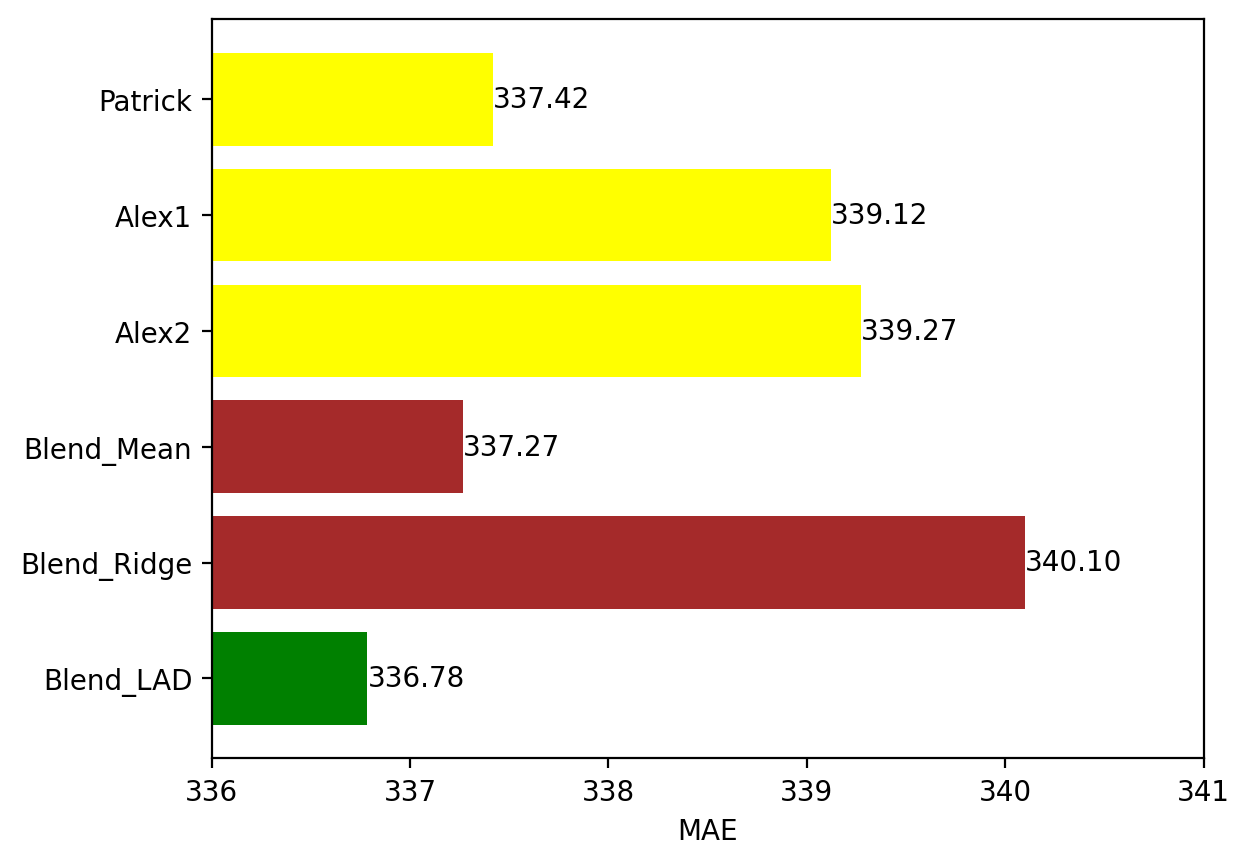

In [27]:
bars = plt.barh(result_df.index, result_df, color=["yellow", "yellow", "yellow", "brown", "brown", "green"])
plt.gca().bar_label(bars, fmt='%.2f')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.index)
plt.xlabel('MAE')
plt.xlim(336, 341);

## Submission

I will submit LADRegression predictions:

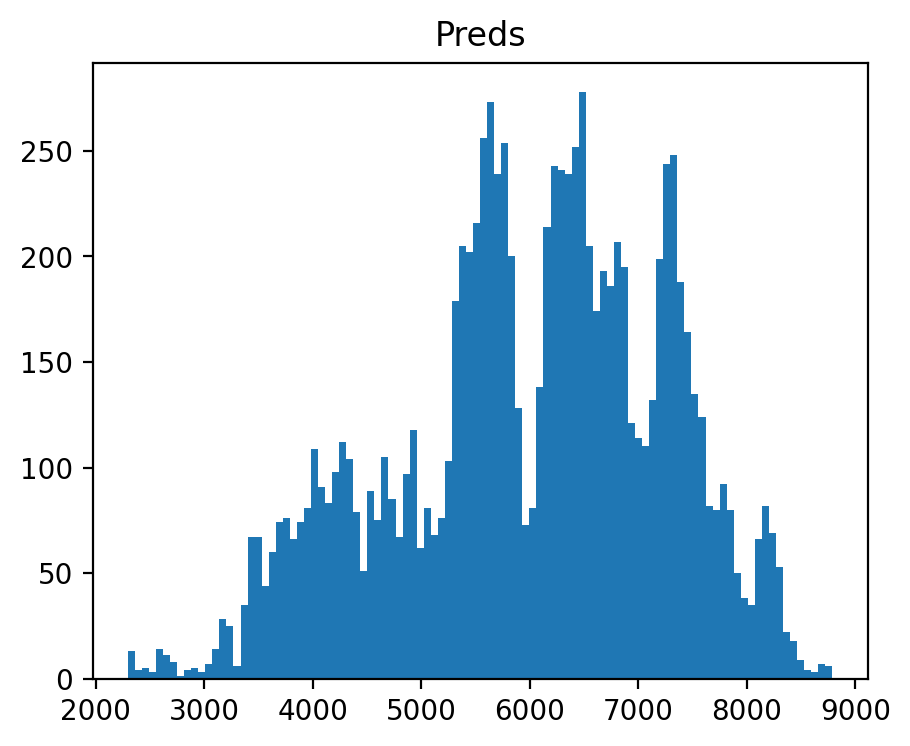

,id,yield
0,15289,4310.812419
1,15290,5882.081137
2,15291,7261.243958
3,15292,4526.539886
4,15293,3833.543450
5,15294,5131.776815
6,15295,7142.821797
7,15296,6447.674628
8,15297,8279.699722
9,15298,4265.644717


In [28]:
sub = pd.DataFrame(index=test.index)
sub["yield"] = LADRegression_blend.predict(preds)
sub["yield"].to_csv("submission.csv")

sub = pd.read_csv("/kaggle/working/submission.csv")
plt.figure(figsize=(5, 4))
plt.title('Preds')
plt.hist(sub[target], bins=100)
plt.show()

sub.head(10)